In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import mean_squared_error,r2_score

#load temporal coefficients
C=np.load("C.npy") #pod modes
X=np.load("X.npy") #data to test
X_features=C.T
y=X[1,:]
print(X_features.shape,y.shape)

(5844, 10) (5844,)


In [3]:
#split the data
x_train,x_test,y_train,y_test=train_test_split(X_features,y,test_size=0.2,random_state=42)
#name of models
models={"Linear Regression":LinearRegression(),"Random Forest":RandomForestRegressor(n_estimators=200,random_state=42),"Gradient Boosting Regression":GradientBoostingRegressor(loss='absolute_error', learning_rate=0.1, n_estimators=300, max_depth=5, random_state=42, max_features=5)}
results={} #for storing mse,r2 scores
#use models to predict
for name,model in models.items():
    model.fit(x_train,y_train)
    y_pred=model.predict(x_test)
    mse=mean_squared_error(y_test,y_pred)
    r2=r2_score(y_test,y_pred)
    print(f"{name}: MSE={mse:.4f}, R2={r2:.4f}")
    results[name]=(mse,r2)

Linear Regression: MSE=0.0523, R2=0.9982
Random Forest: MSE=1.4683, R2=0.9482
Gradient Boosting Regression: MSE=0.8904, R2=0.9686


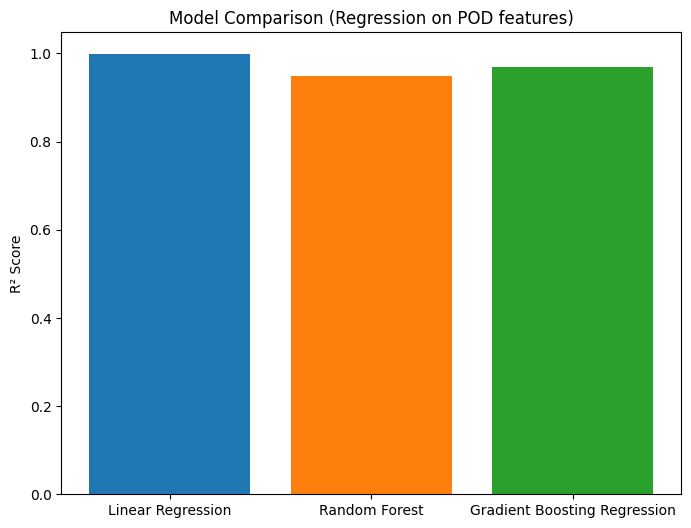

In [4]:
#visual
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
for name, (mse, r2) in results.items():
    plt.bar(name, r2)
plt.ylabel("R² Score")
plt.title("Model Comparison (Regression on POD features)")
plt.xticks()
plt.show()

Linear regression gives the r2_score value close to 1 among the three models with the value 0.9982. Hence, the POD modes can be said as linearly correlated with the target rainfall predictions.

In [5]:
from sklearn.model_selection import cross_val_score

cv_results = {name: [] for name in models.keys()}

# For each model, do 5-fold CV
for name,model in models.items():
        scores = cross_val_score(model, X_features, y, cv=5, scoring="r2")
        cv_results[name].append(scores.mean())
        print(f"{name},  CV R² mean={scores.mean():.4f}")


Linear Regression,  CV R² mean=0.9987
Random Forest,  CV R² mean=0.9496
Gradient Boosting Regression,  CV R² mean=0.9685


In [6]:
#test in raw data
x_features=np.delete(X,1,axis=0)
x1_train,x1_test,y1_train,y1_test=train_test_split(x_features.T,y,test_size=0.2,random_state=42)
results1={} #for storing mse,r2 scores
#use models to predict
for name,model in models.items():
    model.fit(x1_train,y1_train)
    y_pred1=model.predict(x1_test)
    mse1=mean_squared_error(y1_test,y_pred1)
    r21=r2_score(y1_test,y_pred1)
    print(f"{name}: MSE={mse1:.4f}, R2={r21:.4f}")
    results1[name]=(mse1,r21)

Linear Regression: MSE=21.8915, R2=0.2275
Random Forest: MSE=16.3158, R2=0.4243
Gradient Boosting Regression: MSE=17.3551, R2=0.3876


In [7]:
#comparison table
comparison=pd.DataFrame({"Raw MSE":{k:v[0] for k,v in results1.items()},"Raw R2":{k:v[1] for k,v in results1.items()},"POD MSE":{k:v[0] for k,v in results.items()},"POD R2":{k:v[1] for k,v in results.items()}})
print("_____Comparison Table_____")
# Display bordered table
comparison.style.set_table_styles(
    [{
        'selector': 'th, td',
        'props': [('border', '2px solid black'),
                  ('padding', '5px')]
    }]
).set_properties(**{'text-align': 'center'})


_____Comparison Table_____


,Raw MSE,Raw R2,POD MSE,POD R2
Linear Regression,21.891498,0.227537,0.052285,0.998155
Random Forest,16.315762,0.424283,1.468318,0.948189
Gradient Boosting Regression,17.355060,0.387610,0.890432,0.968580


The performance of models are better using POD than raw data.

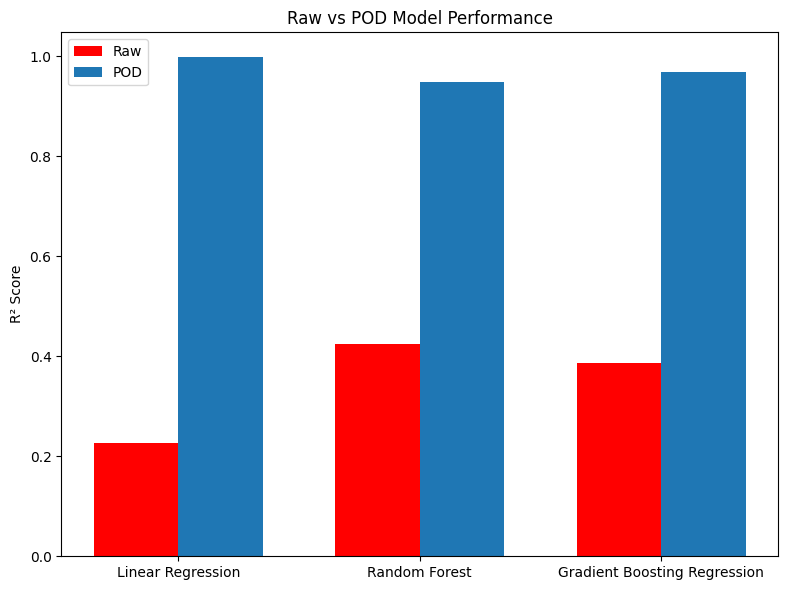

In [12]:
# Bar plot for R²

labels = list(models.keys())
raw_r2 = [results1[m][1] for m in labels]
pod_r2 = [results[m][1] for m in labels]

x = np.arange(len(labels))  # model positions
width = 0.35
plt.figure(figsize=(8,6))
plt.bar(x - width/2, raw_r2, width, label="Raw",color="red")
plt.bar(x + width/2, pod_r2, width, label="POD")
plt.xticks(x, labels)
plt.ylabel("R² Score")
plt.title("Raw vs POD Model Performance")
plt.legend()
plt.tight_layout()
plt.show()

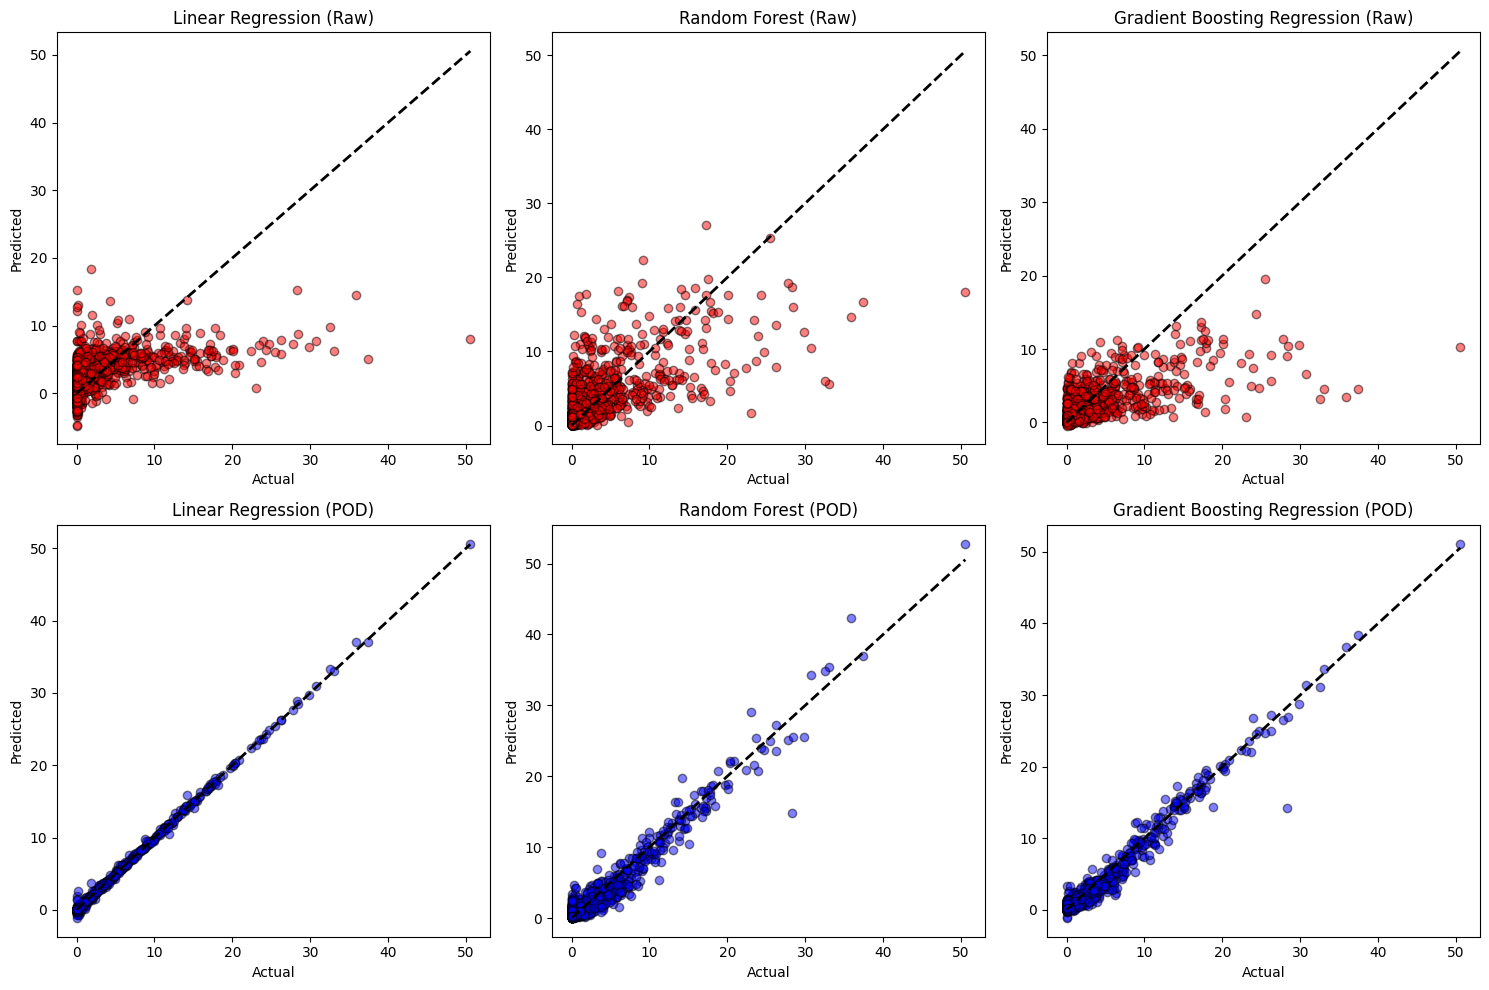

In [13]:
#scatter plot
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # 2 rows: Raw vs POD, 3 cols: models
axes = axes.ravel()

for i, (name, model) in enumerate(models.items()):
    # --- RAW ---
    model.fit(x1_train, y1_train)
    y_pred_raw = model.predict(x1_test)
    axes[i].scatter(y1_test, y_pred_raw, alpha=0.5, color="red", edgecolor="k")
    axes[i].plot([y1_test.min(), y1_test.max()],
                 [y1_test.min(), y1_test.max()],
                 'k--', lw=2)
    axes[i].set_title(f"{name} (Raw)")
    axes[i].set_xlabel("Actual")
    axes[i].set_ylabel("Predicted")

    # --- POD ---
    model.fit(x_train, y_train)
    y_pred_pod = model.predict(x_test)
    axes[i+3].scatter(y_test, y_pred_pod, alpha=0.5, color="blue", edgecolor="k")
    axes[i+3].plot([y_test.min(), y_test.max()],
                   [y_test.min(), y_test.max()],
                   'k--', lw=2)
    axes[i+3].set_title(f"{name} (POD)")
    axes[i+3].set_xlabel("Actual")
    axes[i+3].set_ylabel("Predicted")

plt.tight_layout()
plt.show()
